In [15]:
import qutip
qutip.__version__

'5.2.2'

In [16]:
import contextlib
import dataclasses
import time

import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

from qutip import *
from qutip.core.environment import LorentzianEnvironment
from qutip.solver.heom import HEOMSolver

from IPython.display import display
from ipywidgets import IntProgress
%matplotlib inline

In [17]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [18]:
# Paramètres du système
epsilon = -5
U = 10

# Opérateurs de Pauli
sm = destroy(2)  # σ-
sz = sigmaz()
I = qeye(2)      # identité 2x2

# Opérateurs d'annihilation avec transformation de Jordan-Wigner
# d_up = σ- ⊗ I
d_up = tensor(sm, I)

# d_dn = -σz ⊗ σ-
d_dn = tensor(-sz, sm)

# Hamiltonien du système Anderson
H_sys = epsilon * (d_up.dag() * d_up + d_dn.dag() * d_dn) + U * (d_up.dag() * d_up * d_dn.dag() * d_dn)

# Affichage
print(H_sys)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.  0.  0.  0.]
 [ 0. -5.  0.  0.]
 [ 0.  0. -5.  0.]
 [ 0.  0.  0.  0.]]


In [19]:
@dataclasses.dataclass
class LorentzianBathParameters:
    Q: object  # coupling operator
    gamma: float = 2.0  # coupling strength
    W: float = 10  # cut-off
    T: float = 0.025851991  # temperature
    theta: float = 2  # bias

    def __post_init__(self):
        self.beta = 1 / self.T
        self.mu = self.theta / 2.0

    def J(self, w):
        """ Spectral density. """
        return self.gamma * self.W**2 / ((w - self.mu)**2 + self.W**2)

    def fF1(self, w):
        """ Fermi distribution for this bath. """
        x = (1.0) * self.beta * (w - self.mu)
        return fF(x)

    def lamshift(self, w):
        """ Return the lamb shift. """
        return 0.5 * (w - self.mu) * self.J(w) / self.W

    def replace(self, **kw):
        return dataclasses.replace(self, **kw)


    def fF(self, x):
        """ Return the Fermi distribution. """
        # in units where kB = 1.0
        return 1 / (np.exp(x) + 1)
        
bath1 = LorentzianBathParameters(Q=d_up + d_dn)
bath2 = LorentzianBathParameters(Q=d_dn + d_dn)
bath = bath2 

In [22]:
options = {
    "nsteps": 1500,
    "store_states": True,
    "store_ados": True,
    "rtol": 1e-12,
    "atol": 1e-12,
    "method": "vern9",
    "progress_bar": "enhanced",
}

In [23]:
# Times to solve for and initial system state:
tlist = np.linspace(0, 50, 1000)
from qutip import Qobj
import numpy as np

dims = [[2, 2], [2, 2]]
rho_0 = np.array([[1, 0, 0, 0],
                 [0, 0, 0, 0],
                 [0, 0, 0, 0],
                 [0, 0, 0, 0]])  # Matrice identité
rho_0 = Qobj(rho_0, dims=dims)

rho_1 = np.array([[0, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 0],
                 [0, 0, 0, 0]])  # Matrice identité
rho_1 = Qobj(rho_1, dims=dims)

rho_2 = np.array([[0, 0, 0, 0],
                 [0, 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 0]])  # Matrice identité
rho_2 = Qobj(rho_2, dims=dims)

rho_3 = np.array([[0, 0, 0, 0],
                 [0, 0, 0, 0],
                 [0, 0, 0, 0],
                 [0, 0, 0, 1]])  # Matrice identité
rho_3 = Qobj(rho_3, dims=dims)




Nk = 5  # Number of exponents to retain in the expansion of each bath

env = LorentzianEnvironment(
    bath.T, bath.mu, bath.gamma, bath.W,
)
env_pade = env.approx_by_pade(Nk=Nk)

with timer("RHS construction time"):
    solver_pade = HEOMSolver(
        H_sys,
        (env_pade, bath.Q),
        max_depth=2,
        options=options,
    )

with timer("ODE solver time"):
    result_pade = solver_pade.run(rho_0, tlist)

with timer("Steady state solver time"):
    rho_ss_pade, ado_ss_pade = solver_pade.steady_state()

RHS construction time: 0.09477806091308594
 Total run time:   3.44s*] Elapsed 3.43s / Remaining 00:00:00:00
ODE solver time: 3.4370620250701904
Steady state solver time: 0.019780397415161133


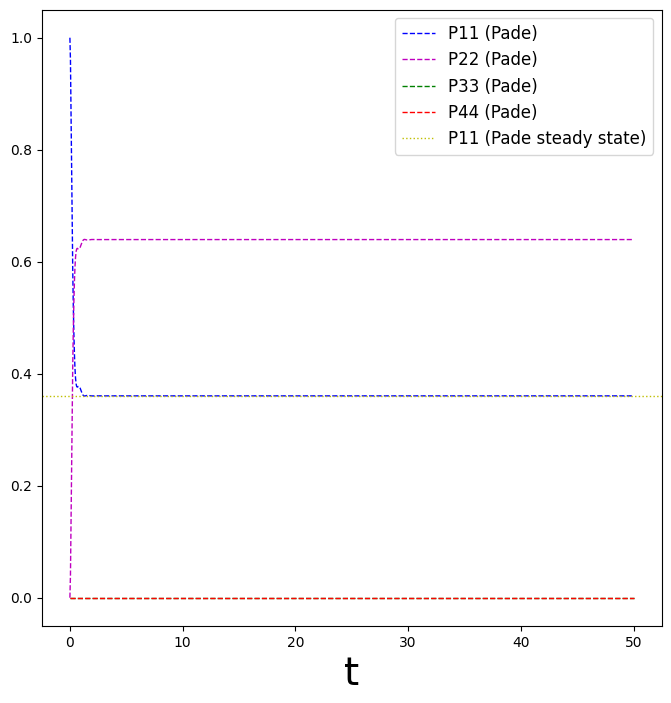

In [24]:
# Plot the Pade results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))

axes.plot(
    tlist, expect(result_pade.states, rho_0),
    'b--', linewidth=1,
    label="P11 (Pade)",
)
axes.plot(
    tlist, expect(result_pade.states, rho_1),
    'm--', linewidth=1,
    label="P22 (Pade)",

)

axes.plot(
    tlist, expect(result_pade.states, rho_2),
    'g--', linewidth=1,
    label="P33 (Pade)",
    
)

axes.plot(
    tlist, expect(result_pade.states, rho_3),
    'r--', linewidth=1,
    label="P44 (Pade)",
    
)

axes.axhline(
    expect(rho_ss_pade, rho_0),
    color='y', linestyle="dotted", linewidth=1,
    label="P11 (Pade steady state)",
)

axes.set_xlabel('t', fontsize=28)
axes.legend(fontsize=12);
plt.savefig("populations_s.png")

In [25]:

env_mats = env.approx_by_matsubara(Nk=Nk)



with timer("RHS construction time"):
    solver_mats = HEOMSolver(
        H_sys,
        (env_mats, bath.Q),
        max_depth=2,
        options=options,
    )

with timer("ODE solver time"):
    result_mats = solver_mats.run(rho_0, tlist)

RHS construction time: 0.08645963668823242
 Total run time:   3.59s*] Elapsed 3.59s / Remaining 00:00:00:00
ODE solver time: 3.5929248332977295
Steady state solver time: 0.021408557891845703


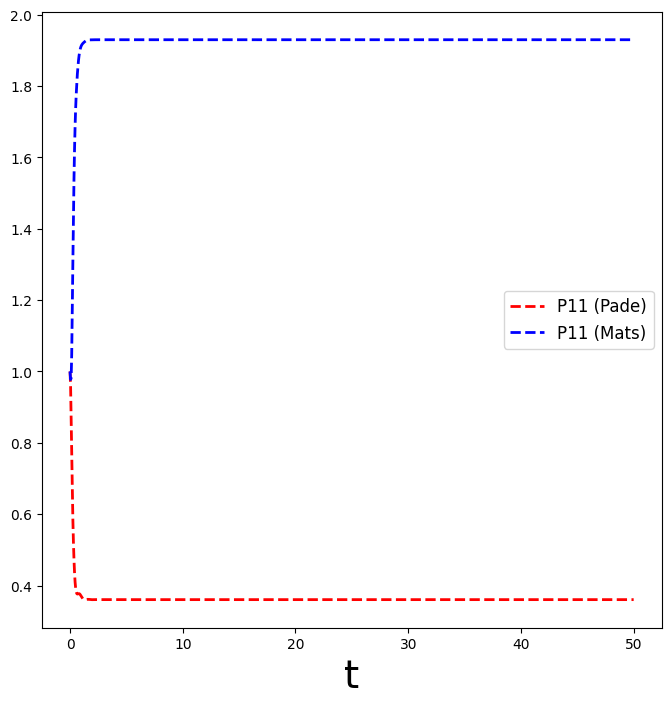

In [27]:
# Plot the Pade results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))

axes.plot(
    tlist, expect(result_pade.states, rho_0),
    'r--', linewidth=2,
    label="P11 (Pade)",
)

axes.plot(
    tlist, expect(result_mats.states, rho_0),
    'b--', linewidth=2,
    label="P11 (Mats)",
)

axes.set_xlabel('t', fontsize=28)
axes.legend(fontsize=12);
#plt.savefig("rho11.png")